<a href="https://colab.research.google.com/github/ArthurFDLR/Image_Boundaries_Analysis/blob/main/Image_Boundaries_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
from cv2 import filter2D
from matplotlib import pyplot as plt
from skimage import io

In [11]:
def draw_border(border:np.ndarray, img_shape):
    img = np.zeros(img_shape)
    if border.dtype == np.complex_:
        for c in border:
            img[int(c.imag), int(c.real)] = 1.
    else:
        for c in border:
            img[int(c[0]), int(c[1])] = 1.
    return img

# Global thresholding

The following algorithm describes a basic global thresholding method for an image $f$:

1. Select an initial estimate for the global threshold $T$.

2. Segment the image using the function $g$. This will produce two groups of pixels $G_+$ and $G_-$.
    
    $$ g(x,y) = \left\{
    \begin{array}{ll}
        1 \mbox{ if } f(x,y) > T \\
        0 \mbox{ otherwise }
    \end{array}
    \right. $$

3. Compute the average (mean) intensity values $m_+$ and $m_-$ for the pixels in $G_+$ and $G_-$ respectively.

4. Compute a new threshold value:

    $$ T = \frac{m_+ + m_-}{2} $$

5. Repeat Steps 2 through 4 until the difference between values of $T$ in successive iterations is smaller than a predefined parameter $\Delta_T$.

Our program is a direct implementation of the above algorithm in Python with an initial threshold value of half the maximum intensity in the image and $\Delta_T=1$. $T$ being an integer, the algorithm stops when T no longer evolve.

In [12]:
def basic_global_tresholding(img):
    delta_T = 1
    T = np.max(img) // 2 # Step 1
    T_old = T + delta_T
    while abs(T - T_old) >= delta_T: # Step 5
        img_treshold = (img > T) # Step 2
        m1, m2 = img[~img_treshold].mean(), img[img_treshold].mean() # Step 3
        T_old, T = T, (m1 + m2)//2 # Step 4
    return (img >= T)*1, T

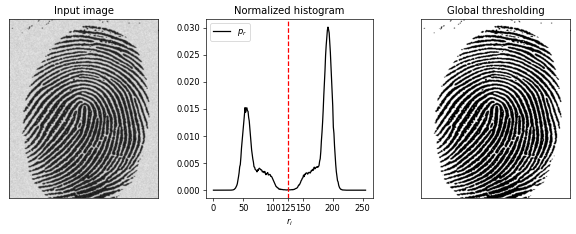

In [36]:
# Image import
img = io.imread('https://github.com/ArthurFDLR/Image_Boundaries_Analysis/blob/main/test_images/noisy_fingerprint.tif?raw=True')

# Computation
img_tresholded, treshold = basic_global_tresholding(img)

# Visualization
fig, axs = plt.subplots(1, 3, figsize=(10,4),dpi=60)
hist,bins = np.histogram(img.flatten(),256,[0,256])
axs[0].set_title("Input image")
axs[0].imshow(img, cmap='gray'), axs[0].set_xticks([]), axs[0].set_yticks([])
axs[1].set_title("Normalized histogram")
axs[1].plot(hist/np.prod(img.shape), c='k', label=r'$p_r$')
axs[1].legend()
axs[1].set_xlabel(r"$r_i$")
axs[1].axvline(x=treshold, label='Treshold', c='r', ls='dashed')
axs[1].set_xticks(list(range(0,255,50)) + [int(treshold)])
axs[2].set_title("Global thresholding")
axs[2].imshow(img_tresholded, cmap='gray'), axs[2].set_xticks([]), axs[2].set_yticks([])
fig.tight_layout()

# Otsu’s thresholding

While the basic global thresholding successfully finds a good thresholding value for histogram presenting well-defined peeks, it performs poorly otherwise.
The critical characteristic of good thresholding is the optimization of separation between classes according to their intensity values. This separation can be mathematically formalized as and is the between-class variance $\sigma_N^2$. Otsu's thresholding algorithm revolves around this observation to find an optimal threshold:

1. Compute the normalized histogram $\left\{p_i, \forall i \in [\![0, L-1]\!]\right\}$ of the input image.

2. Compute the cumulative sums, $\forall k \in [\![0, L-1]\!]$
    $$ P(k) = \sum_{i=0}^k p_i $$

3. Compute the cumulative means, $\forall k \in [\![0, L-1]\!]$
    $$ m(k) = \sum_{i=0}^k i p_i $$
    Note that the global intensity mean $m_g=m(L-1)$.

4. Compute the between-class variance, $\forall k \in [\![0, L-1]\!]$

5. Obtain the Otsu threshold, $k^*$, as the value of $k$ for which $\sigma_B^2(k)$ is maximum. If the maximum is not unique, obtain $k^*$ by averaging the values of corresponding to the various maxima detected.
    $$ k^* = < argmax_{\ k \in [\![0, L-1]\!]} \left( \sigma_B^2(k)\right) > $$

In [14]:
def otsu_tresholding(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256]) # Step 1
    hist = hist/np.prod(img.shape)
    cdf = hist.cumsum() # Step 2
    cmf = np.cumsum([p*i for (i, p) in enumerate(hist)]) # Step 3
    bcv = np.array(
        [(cmf[-1] * P - m)**2 / (P * (1. - P)) if (P * (1. - P)) != 0. else 0. \
         for P, m in zip(cdf, cmf)]
    ) # Step 4
    T = bcv.argmax().mean() # Step 5
    return 1*(img > T), T

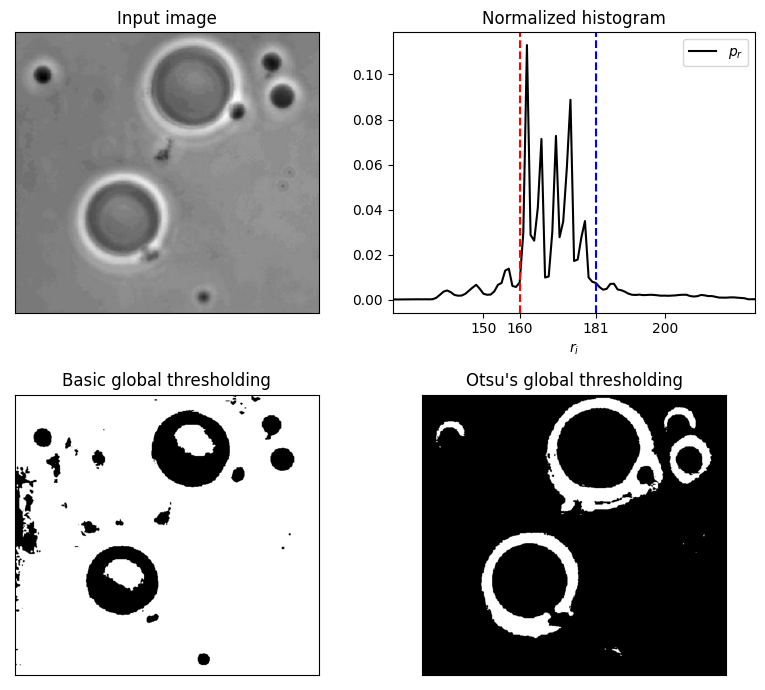

In [16]:
# Image import
img = io.imread('https://github.com/ArthurFDLR/Image_Boundaries_Analysis/blob/main/test_images/polymersomes.tif?raw=True')

# Computation
img_tresholded_otsu, treshold_otsu = otsu_tresholding(img)
img_tresholded, treshold = basic_global_tresholding(img)

# Visualization
fig, axs = plt.subplots(2, 2, figsize=(8,7), dpi=60)
axs = [ax for sub_ax in axs for ax in sub_ax]

hist,bins = np.histogram(img.flatten(),256,[0,256])
axs[0].set_title("Input image")
axs[0].imshow(img, cmap='gray'), axs[0].set_xticks([]), axs[0].set_yticks([])
axs[1].set_title("Normalized histogram")
axs[1].plot(hist/np.prod(img.shape), c='k', label=r'$p_r$')
axs[1].legend()
axs[1].set_xlabel(r"$r_i$")
axs[1].axvline(x=treshold, c='r', ls='dashed')
axs[1].axvline(x=treshold_otsu, c='b', ls='dashed')
axs[1].set_xticks(list(range(0,255,50)) + [int(treshold), int(treshold_otsu)])
axs[1].set_xlim(125, 225)
axs[2].set_title("Basic global thresholding")
axs[2].imshow(img_tresholded, cmap='gray'), axs[2].set_xticks([]), axs[2].set_yticks([])
axs[3].set_title("Otsu's global thresholding")
axs[3].imshow(img_tresholded_otsu, cmap='gray'), axs[3].set_xticks([]), axs[3].set_yticks([])

fig.tight_layout()

The input image's histogram does not present distinctive peeks, allowing to telling apart the foreground from the background. As expected, the basic global thresholding method yields poor results. The background is partially detected as a zone of interest on the left side of the image. Otsu's algorithm fixes this issue.

# Chain codes

This problem's end goal is to generate the integer of the minimum magnitude of the Freeman chain code of an object in an image. We can decompose this problem into two primary steps. First, we have to find the boundary of the shape. The shape must present clean and sharp edges. We can remove the noises and sharpen the image using a combination of a $9 \times 9$ averaging filter and Otsu's algorithm. The boundary following algorithm is then ideally suited to our application:

1. Let the starting point, $b_0$, be the uppermost-leftmost point in the image. Store its coordinates. Denote by $c_0$ the west neighbor of $b_0$. Examine the 8-neighbors of $b_0$ starting at $c_0$ and proceeding in a clockwise direction. Let $b_1$ denote the first neighbor encountered whose value is 1, and let $c_1$ be the (background) point immediately preceding $b_1$ in the sequence.

2. Initiate a couple of variables, $b=b_1$ and $c=c_1$.

3. Let the N-neighbors (N being 4 or 8) of $b$, starting at $c$ and proceeding in a clockwise direction, be denoted by $\{n_i, \forall i \in [\![0, N-1]\!]\}$. Find the first $n_k$ labeled 1.

4. Let $b=n_k$ and $c=n_{k-1}$.

5. Repeat Steps 3 and 4 until $b=b_0$ and the next boundary point found is The sequence of points found when the algorithm stops constitutes the set of ordered boundary points

![Illustration of the first few steps in the boundary-following algorithm (Digital Image Processing by Gonzalez & Woods)](https://github.com/ArthurFDLR/Image_Boundaries_Analysis/blob/main/.github/bound_follow.PNG?raw=True)

The Freeman chain code is generally used as a characteristic to compare or detect shapes across images. Only the global figure is interesting. Fine details can thus be considered as noise regarding the overall shape. To avoid this issue, we can down-sample the boundary.

We are now all set to compute the chain code. The difference between coordinates of consecutive boundary pixel can be mapped to the directions shown bellow. The index of the following lists corresponds to the direction number of the relative coordinate (e.g. $(0,1) \longrightarrow 0$ and $(-1,-1) \longrightarrow 3$ for 8-directional encoding).

$$ x_n = [0, -1, -1, -1,  0,  1, 1, 1] $$
$$ y_n = [1,  1,  0, -1, -1, -1, 0, 1] $$

![Direction numbers for 4-directional and 8-directional chain code (Digital Image Processing by Gonzalez & Woods)](https://github.com/ArthurFDLR/Image_Boundaries_Analysis/blob/main/.github/direction.PNG?raw=True)

In [32]:
def find_upper_left(img):
    for i in range(1,img.shape[0]+1):
        for j in range(i):
            if img[i-j-1, j]:
                return (i-j-1, j)
    return None

def resample(img, grid_width, presence_threshold=0):
    img_sub = np.zeros(np.array(img.shape)//grid_width)
    img_sub_viz = np.zeros(img.shape)
    gw_half = grid_width // 2
    for x_sub, x in enumerate(range((img.shape[0]%grid_width)//2 + gw_half, img.shape[0], grid_width)):
        for y_sub, y in enumerate(range((img.shape[1]%grid_width)//2 + gw_half, img.shape[1], grid_width)):
            if img[x-gw_half:x+gw_half, y-gw_half:y+gw_half].sum() > presence_threshold:
                img_sub[x_sub,y_sub] = 1
                img_sub_viz[x-1:x+2, y-1:y+2] = np.ones((3,3))
    return img_sub, img_sub_viz

def boundary_following(border, stay_out=True, allow_diag=True):
    
    x_n = [0, -1, -1, -1,  0,  1, 1, 1] if allow_diag else [0, -1,  0, 1]
    y_n = [1,  1,  0, -1, -1, -1, 0, 1] if allow_diag else [1,  0, -1, 0]
    nbr_neighbore = len(x_n)
    angle = nbr_neighbore//2
    
    def get_neighbor(p,a):
        x, y = p[0] + x_n[a], p[1] + y_n[a]
        if (0 <= x < border.shape[0]) and (0 <= y < border.shape[1]):
            return border[x, y]
        else: return None

    b = find_upper_left(border)
    b_init = False
    coord_border = [b]
    chain_code = []

    while True:
        # Revolve around b until hit border
        while not get_neighbor(b, angle):
            angle = (angle - 1) if angle else (nbr_neighbore - 1)
        # Prefer direct neighbore
        if (not stay_out) and allow_diag and (angle%2 == 1) \
            and get_neighbor(b, (angle - 1) if angle else 7):
            angle = (angle - 1) if angle else (nbr_neighbore - 1)
        # Update b <- n(k)
        b = (b[0] + x_n[angle], b[1] + y_n[angle])
        # End condition: two successive boundary pixels already visited
        if b_init:
            if b == coord_border[1]: break
            else: b_init = False
        if b == coord_border[0]: b_init = True
        # Store new border pixel
        chain_code.append(angle)
        coord_border.append(b)
        # Reset angle, c <- n(k−1)
        angle = (angle+angle%2+2)%8 if allow_diag else (angle+1)%4
    return np.array(coord_border), chain_code

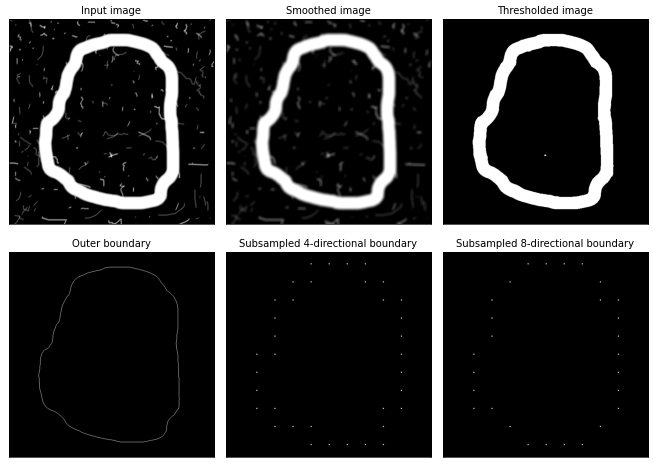

In [24]:
# Image import
img = io.imread('https://github.com/ArthurFDLR/Image_Boundaries_Analysis/blob/main/test_images/circular_stroke.tif?raw=True')

# Computation
kernel_smoothing = np.ones((9,9),np.float32)/(9*9)
img_g = filter2D(img,-1,kernel_smoothing)
img_gB, _ = otsu_tresholding(img_g)
gB_border, _ = boundary_following(img_gB)
img_gB_border = draw_border(gB_border, img.shape)
img_gB_border_resampled_4, sampled_viz_4 = resample(img_gB_border, 50, 0)
img_gB_border_resampled_8, sampled_viz_8 = resample(img_gB_border, 50, 25)

# Visualization
fig, axs = plt.subplots(2, 3, figsize=(11,8), dpi=60)
axs = [ax for sub_ax in axs for ax in sub_ax]
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

axs[0].set_title('Input image')
axs[0].imshow(img, cmap='gray')
axs[1].set_title('Smoothed image')
axs[1].imshow(img_g, cmap='gray')
axs[2].set_title('Thresholded image')
axs[2].imshow(img_gB, cmap='gray')
axs[3].set_title('Outer boundary')
axs[3].imshow(img_gB_border, cmap='gray')
axs[4].set_title('Subsampled 4-directional boundary')
axs[4].imshow(sampled_viz_4, cmap='gray')
axs[5].set_title('Subsampled 8-directional boundary')
axs[5].imshow(sampled_viz_8, cmap='gray')

fig.tight_layout()

In [19]:
def get_first_diff(chain_code):
    nbr_direction = max(chain_code)+1
    out = [(nbr_direction+chain_code[0]-chain_code[-1])%nbr_direction]
    for i in range(len(chain_code)-1):
        out.append((nbr_direction+chain_code[i+1]-chain_code[i])%nbr_direction)
    return out 

def get_magnitude(l):
    out = 0
    for i in l:
        out = out * 10 + i
    return out

def get_min_mag(chain_code):
    mini = get_magnitude(chain_code)
    mini_chain = chain_code
    for i in range(1,len(chain_code)):
        c = chain_code[i:] + chain_code[:i]
        mag_c = get_magnitude(c)
        if mag_c<mini:
            mini = mag_c
            mini_chain = c
    return mini_chain

In [10]:
print('4-directional:')
_, chain_code_4 = boundary_following(img_gB_border_resampled_4, stay_out=False, allow_diag=False)
print("Chain code:\t\t", chain_code_4)

chain_code_diff_4 = get_first_diff(chain_code_4)
print("First difference:\t", chain_code_diff_4)

chain_code_diff_min_4 = get_min_mag(chain_code_diff_4)
print("Minimum magnitude:\t",chain_code_diff_min_4)

print('\n8-directional:')
_, chain_code_8 = boundary_following(img_gB_border_resampled_8, stay_out=False)
print("Chain code:\t\t", chain_code_8)

chain_code_diff_8 = get_first_diff(chain_code_8)
print("First difference:\t", chain_code_diff_8)

chain_code_diff_min_8 = get_min_mag(chain_code_diff_8)
print("Minimum magnitude:\t",chain_code_diff_min_8)

4-directional:
Chain code:		 [0, 1, 0, 1, 0, 0, 0, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1]
First difference:	 [3, 1, 3, 1, 3, 0, 0, 3, 1, 3, 1, 3, 0, 0, 0, 0, 0, 3, 1, 0, 3, 0, 0, 0, 3, 1, 0, 3, 1, 3, 0, 0, 3, 1, 0, 0]
Minimum magnitude:	 [0, 0, 0, 0, 0, 3, 1, 0, 3, 0, 0, 0, 3, 1, 0, 3, 1, 3, 0, 0, 3, 1, 0, 0, 3, 1, 3, 1, 3, 0, 0, 3, 1, 3, 1, 3]

8-directional:
Chain code:		 [1, 1, 0, 0, 0, 7, 6, 0, 6, 6, 6, 6, 6, 6, 5, 5, 4, 4, 4, 3, 3, 4, 2, 2, 2, 1, 2, 2]
First difference:	 [7, 0, 7, 0, 0, 7, 7, 2, 6, 0, 0, 0, 0, 0, 7, 0, 7, 0, 0, 7, 0, 1, 6, 0, 0, 7, 1, 0]
Minimum magnitude:	 [0, 0, 0, 0, 0, 7, 0, 7, 0, 0, 7, 0, 1, 6, 0, 0, 7, 1, 0, 7, 0, 7, 0, 0, 7, 7, 2, 6]


# Fourier Descriptors

The Fourier Transform (FT) has proven to be extremely useful in computer vision and signal processing in general. Once again, we can take advantage of the frequency representation of the shape's boundary series. There is a couple of significant application associated to different intensity of low-pass frequency filter. First, we can reduce the quantity of data used to describe a boundary with virtually no resolution loss. Secondly, a strong low-pass filter can smooth the boundary to ease comparison.

At first sight, one can think about using a 2D FT to generate the frequency description of a boundary due to its visual nature. However, boundaries really are one-dimensional. Each coordinate pair can be treated as a complex number. Consider a boundary $\left\{\left(x_i, y_i\right), \forall i \in [\![0, K-1]\!] \right\}$,

$$ s(k) = y(k) + j \cdot x(k) $$

The classical one-dimensional Fourier Transform can be applied to this complex representation to obtain the Fourier descriptors $a(u)$ of the boundary. $\forall u \in [\![0, K-1]\!]$

$$ a(u) = \sum_{k=0}^{K-1} s(k) \cdot e^{-j 2 \pi \frac{uk}{K}} $$

Then, we can reconstruct the border using only a fraction of the available Fourier descriptors. Consider $P < K$ descriptors, $\forall p \in [\![0, P-1]\!]$

$$ \widehat{s}(p) = \frac{1}{K} \sum_{u=0}^{P-1} a(u) \cdot e^{j 2 \pi \frac{up}{K}} $$

In [21]:
def fourierdescp(s):
    return np.fft.fft(s, len(s))

def ifourierdescp(a, P):
    P = min(len(a), P)
    mid = len(a) // 2
    low  = mid - P // 2
    high = mid + P // 2
    a_trunc = np.zeros(a.shape, np.complex_)
    a_trunc[low:high] = np.fft.fftshift(a)[low:high]
    return np.fft.ifft(np.fft.ifftshift(a_trunc))

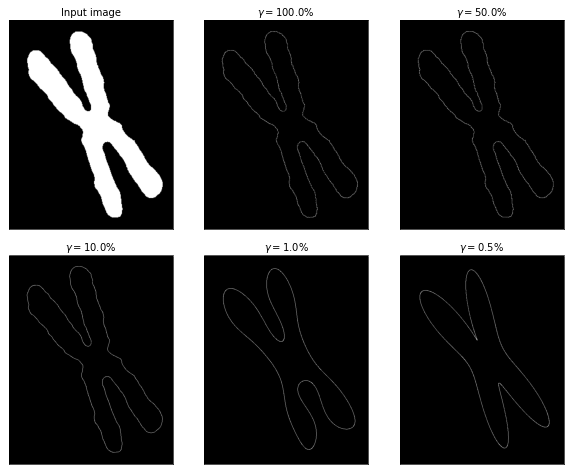

In [26]:
# Image import
img = io.imread('https://github.com/ArthurFDLR/Image_Boundaries_Analysis/blob/main/test_images/chromosome.tif?raw=True')

# Computation
border_coord, _ = boundary_following(img)
img_border = draw_border(border_coord, img.shape)
border_complex = np.array([c[1] + 1j * c[0] for c in border_coord])
fourier_descriptors = fourierdescp(border_complex)
FD_size = fourier_descriptors.shape[0]

# Vizualisation
fig, axs = plt.subplots(2, 3, figsize=(10,8), dpi=60)
axs_flat = [ax for sub_ax in axs for ax in sub_ax]
for ax in axs_flat:
    ax.set_xticks([])
    ax.set_yticks([])

axs_flat[0].set_title('Input image')
axs_flat[0].imshow(img, cmap='gray')
for i, compression in enumerate([1., .5, .1, .01, .005]):
    border_complex_smoothed = ifourierdescp(fourier_descriptors, int(FD_size*compression))
    axs_flat[i+1].set_title(r'$\gamma = ${:.1%}'.format(compression))
    axs_flat[i+1].imshow(draw_border(border_complex_smoothed, img.shape), cmap='gray')

fig.tight_layout()